# Analysis of collider data and `numpy` limitation

**Caution** this notebook needs to have ROOT installed with python and `root_numpy`

In [8]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Usual library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot settings
import matplotlib as mpl
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5

# Time profiling
from timeit import default_timer
import cProfile

# Combinatorics tool
import itertools

# root_numpy (http://scikit-hep.org/root_numpy)
from root_numpy import root2array

# Temporary to import my functions
import np_utils as npu

The first conversion between a `TTree` and a python object is performed using `root_numpy`. Several options are possible, like the list of the branches or a selection string. The obtained object is a numpy array that are converted into a pandas dataframe in order to enjoy all their features (very nice to work with 1D variables, easy to add column on the fly, etc ...).

In [4]:
# Load it with root_numpy
%timeit ar = root2array('collisions.root', 'event_tree').view(np.recarray)

1 loop, best of 3: 1.57 s per loop


In [10]:
ar = root2array('collisions.root', 'event_tree').view(np.recarray)
df = pd.DataFrame(ar)
df.head()

,jet_pt,jet_eta,jet_phi,jet_mv2c10,jet_isbtagged_77,el_pt,el_eta,el_phi,mu_pt,mu_eta,mu_phi,mu
0,"[169695.5, 122250.03]","[-0.39637992, 1.6006567]","[1.4989699, -1.4390093]","[0.9628408, 0.99954563]","[1, 1]","[55366.094, 38978.633]","[1.9268323, 0.13278118]","[-3.0938299, -0.1095593]",[],[],[],3.5
1,"[92278.93, 70800.66, 69653.164, 27776.486]","[0.40425044, 0.96515447, 0.5671447, 0.6175964]","[-1.6717116, 1.0977219, -1.2310998, 0.40548608]","[0.99883986, 0.999752, -0.897119, -0.8301639]","[1, 1, 0, 0]",[],[],[],"[65079.883, 37495.855]","[1.3351973, 0.3574057]","[2.9533806, 3.1300983]",26.5
2,"[56349.285, 43751.82, 36588.938, 35095.082, 27...","[0.56248516, 2.4351118, -1.7529668, 1.2876523,...","[-0.38178313, 1.3481613, -2.3859453, -2.722344...","[0.9999337, -0.7246226, -0.7773614, -0.9201909...","[1, 0, 0, 0, 0]",[76494.64],[-0.31438547],[-1.9961401],[49808.887],[-0.17943819],[-3.1100628],27.5
3,"[59820.547, 41592.062]","[-2.302116, -2.218402]","[1.9511205, 0.5742027]","[-0.82315505, 0.9919272]","[0, 1]",[39917.418],[-1.3356979],[2.6993954],[103460.734],[-2.07254],[-1.3708612],9.5
4,"[196711.52, 123898.07, 87307.625, 82197.49, 41...","[-2.2168732, -0.5487006, -1.6435306, -1.037495...","[-0.24934195, 0.61117375, 1.870176, -2.149553,...","[-0.97217584, -0.9577969, -0.88246375, 0.99995...","[0, 0, 0, 1, 0, 0]",[197385.73],[-0.749733],[-2.845913],[34190.586],[-1.418337],[-1.6127276],12.5


In [11]:
print('Number of events: {:.0f}'.format(len(df)))

Number of events: 250000


# Convert some dataframe column to numpy array

Pandas is very nice and powerful for really numbers (*i.e.* no arrays), while in collider physics we have various collections of physics objects (of various size) for each events. This means two things:
   1. it's very common to have arrays per event and not only numbers
   2. the size of the array will change from an event to another (those are called *jagged arrays*).
   
Doing pure python is not a problem with jagged arrays but it's impossible to benefit from `numpy` vectorization since this requires well defined shape. In practice, the numpy array obtained by `df.values` is a 1D-array of arrays, and not a n-dimenional array:

In [29]:
array_jet_pt = df['jet_pt'].values
print('shape: {}'.format(array_jet_pt.shape))

shape: (250000,)


In order to work around this issue, one can "square jagged arrays" by setting the variable size to the maximum number of objects among all events, and fill empty values with a dummy value (to be carefully chosen depending on your computation). This is exactly what the function `square_jagged_2Darray(a,val=value,nobj=Nmax)` does, as illustrated below. The cell below prints the jet $p_T$ array for the three first event, for different formating of the array. The construction of this function is detailed (and timed) after.

In [23]:
# Raw numbers (ie before squaring)
print('\n\nBefore squaring:')
print('================')
jet_pt_df = df['jet_pt'].values
print('shape: {}'.format(jet_pt_df.shape))
for pt in jet_pt_df[0:3]:
    print(len(pt), pt)

# After squaring
print('\n\nAfter squaring:')
print('===============')
jet_pt_np = npu.square_jagged_2Darray(jet_pt_df, val=-999)
print('shape: {}'.format(jet_pt_np.shape))
for pt in jet_pt_np[0:3]:
    print(len(pt), pt)

# After squaring with Nmax=3 
print('\n\nAfter squaring with Nmax=3:')
print('============================')
jet_pt_np = npu.square_jagged_2Darray(jet_pt_df, val=-999, nobj=3)
print('shape: {}'.format(jet_pt_np.shape))
for pt in jet_pt_np[0:3]:
    print(len(pt), pt)



Before squaring:
shape: (250000,)
(2, array([169695.5 , 122250.03], dtype=float32))
(4, array([92278.93 , 70800.66 , 69653.164, 27776.486], dtype=float32))
(5, array([56349.285, 43751.82 , 36588.938, 35095.082, 27441.059],
      dtype=float32))


After squaring:
shape: (250000, 11)
(11, array([169695.5 , 122250.03,   -999.  ,   -999.  ,   -999.  ,   -999.  ,
         -999.  ,   -999.  ,   -999.  ,   -999.  ,   -999.  ],
      dtype=float32))
(11, array([92278.93 , 70800.66 , 69653.164, 27776.486,  -999.   ,  -999.   ,
        -999.   ,  -999.   ,  -999.   ,  -999.   ,  -999.   ],
      dtype=float32))
(11, array([56349.285, 43751.82 , 36588.938, 35095.082, 27441.059,  -999.   ,
        -999.   ,  -999.   ,  -999.   ,  -999.   ,  -999.   ],
      dtype=float32))


After squaring with Nmax=3:
shape: (250000, 3)
(3, array([169695.5 , 122250.03,   -999.  ], dtype=float32))
(3, array([92278.93 , 70800.66 , 69653.164], dtype=float32))
(3, array([56349.285, 43751.82 , 36588.938], dtype=floa

In [27]:
# Getting the array directly
%timeit df['jet_pt'].values

# Squaring the array
%timeit npu.square_jagged_2Darray(jet_pt_df, val=-999)

# # Squaring the array with max 3 objects
%timeit npu.square_jagged_2Darray(jet_pt_df, val=-999, nobj=3)

The slowest run took 14.98 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.61 µs per loop
1 loop, best of 3: 210 ms per loop
1 loop, best of 3: 212 ms per loop


As it was probably noted, the `square_jagged_2Darray()` is longer than directly taking the numpy array. This is mostly due to two steps: scanning to find the max of object numbers, and the concatenation of all individual arrays. At the end, loading the squared numpy array takes 2-3 seconds only.

In [30]:
# Timing of every key steps of square_jagged_2Darray

# 1. Getting all the sub-array length
%timeit lens = np.array([len(i) for i in jet_pt_df])
lens = np.array([len(i) for i in jet_pt_df])

# 2. Create a mask to know which value should be filled
%timeit mask = np.arange(lens.max()) < lens[:, None]
mask = np.arange(lens.max()) < lens[:, None]

# 3. Initialize the final squared array
%timeit out = np.zeros(mask.shape, dtype='float32')
out = np.zeros(mask.shape, dtype='float32')

# 4. Fill the default values where needed
%timeit out.fill(999)
out.fill(999)

# 5. Fill the array value using concatenate
%timeit out[mask] = np.concatenate(jet_pt_df)
out[mask] = np.concatenate(jet_pt_df)

10 loops, best of 3: 61.1 ms per loop
100 loops, best of 3: 4.14 ms per loop
1000 loops, best of 3: 724 µs per loop
1000 loops, best of 3: 811 µs per loop
10 loops, best of 3: 111 ms per loop


Another function called `df2array()` allows to load several column (with the same maximum size) into a given nd array. This is needed if one wants to make computations based on all those columns. The best example is the $dR$ variable which involves both $\eta$ and $\phi$. These two variables can be grouped in a big numpy array of dimension `(Nevts,Njets,2)`, where 2 corresponds to the number of variables. This function is internally call the np.stack() method (on top of some checks):
```python
jets_kin = npu.df2array(df,['jet_pt','jet_eta','jet_phi'])
```
is equivalent to 
```python
jets_pt  = npu.square_jagged_2Darray(df['jet_pt'].values)
jets_eta = npu.square_jagged_2Darray(df['jet_eta'].values)
jets_phi = npu.square_jagged_2Darray(df['jet_phi'].values)
jets_kin = np.concatenate([jets_pt,jets_eta,jets_phi],axis=2)
```

In [7]:
jets_kin = npu.df2array(df[0:1000], ['jet_pt', 'jet_eta', 'jet_phi'])
print(jets_kin.shape)

jets_btg = npu.df2array(df[0:1000], ['jet_mv2c10', 'jet_isbtagged_77'])
print(jets_btg.shape)

jets = npu.df2array(df[0:1000], ['jet_pt', 'jet_eta',
                                 'jet_phi', 'jet_mv2c10', 'jet_isbtagged_77'])
print(jets.shape)

(1000, 8, 3)
(1000, 8, 2)
(1000, 8, 5)


In [8]:
# Load jet array for all events
jets = npu.df2array(df, ['jet_pt', 'jet_eta', 'jet_phi',
                         'jet_mv2c10', 'jet_isbtagged_77'])

# Producing some non-trivial plots using numpy arrays


Everything which is based on flat number can be directly done pandas columns directly, *e.g.* the following code will be similarly efficient as with a `TTree->Draw()` command.
```python
plt.figure(figsize=(10,7))
ax=plt.hist(df['mu'])
```

But the more tricky part is what to do with python to make some more complex computations **without doing an explicit event loop**? The next sub-sections give some examples.

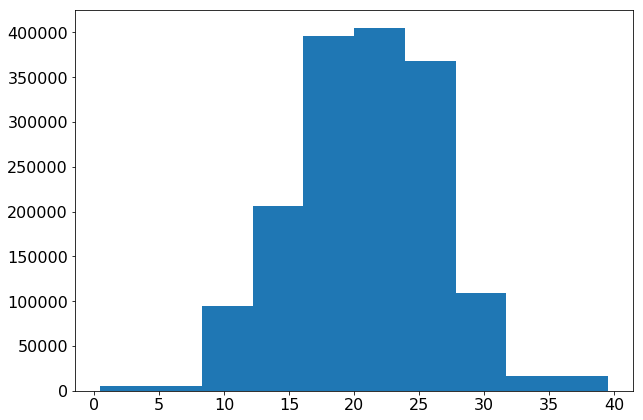

In [9]:
plt.figure(figsize=(10, 7))
ax = plt.hist(df['mu'])

## Jet multiplicity for different $p_T$ thresholds

Looking at the jet multiplicity depending on the $p_T$ threshold: 
   + `jets[...:0]` means that all dimention but the last one is inclusive (here it means all events and all jets for each events), while the 0 means first variable (*i.e.* the $p_T$ since it comes first in the command `df2array(df,['jet_pt','jet_eta','jet_phi','jet_mv2c10','jet_isbtagged_77'])`);
   + `jets[...,0]>pt` is a 2D arrays filled of shape (Nevts,Njets) with `True` and `False` depending on wether the element is above `pt` or not;
   + `np.count_nonzero(jets[...,0]>pt,axis=1)` is 1D array of shape (Nevts) which counts the number of `True` along the Njets axis (so per event).

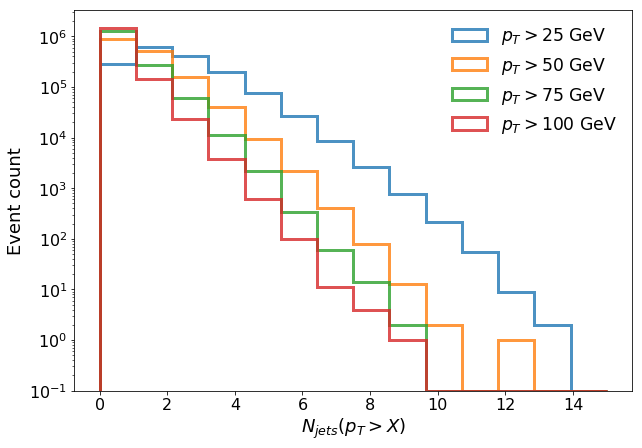

In [10]:
plt.figure(figsize=(10, 7))
for pt in np.linspace(25, 100, 4)*1000:
    ax = plt.hist(np.count_nonzero(jets[..., 0] > pt, axis=1),
                  label='$p_T>{:.0f}$ GeV'.format(pt/1000.),
                  alpha=0.8, histtype='step', linewidth=3,
                  bins=np.linspace(0, 15, 15), log=True)
ax = plt.legend()
ax = plt.xlabel('$N_{jets}(p_T>X)$')
ax = plt.ylabel('Event count')

## Jet $p_T$ distribution for every jets in the event

This is also very easy to look at the $p_T$ distributions of the leading, sub-leading, ... jets. For this, one first needs to replace all `nan` (not a number) by a appropriate default value (0 for instance), otherwise the plotting step will crash (cannot plot `nan`). Then a loop over all the jets is performed (the number of jets is the size of the dimension 2, *i.e.* `shape[1]`).

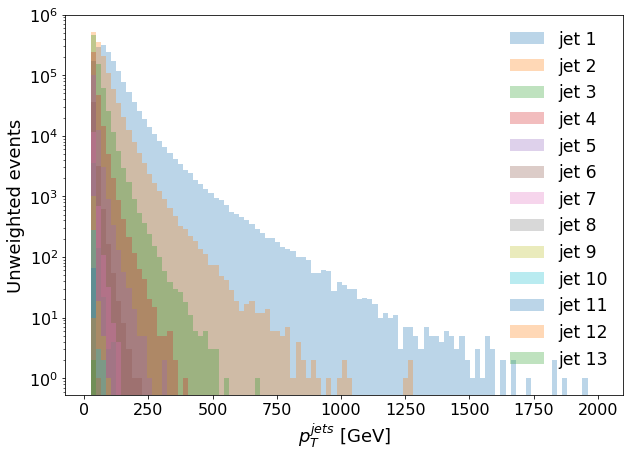

In [11]:
jets_pt_plots = npu.replace_nan(jets[..., 0], value=0)

fig = plt.figure(figsize=(10, 7))
Njets = jets_pt_plots.shape[1]
for i in np.arange(Njets):
    ax = plt.hist(jets_pt_plots[:, i]/1000., alpha=0.3, linewidth=3,
                  bins=np.linspace(25, 2000, 100), log=True, label='jet {}'.format(i+1))
ax = plt.legend()
ax = plt.xlabel('$p^{jets}_T$ [GeV]')
ax = plt.ylabel('Unweighted events')

## $H_T$ distribution in different configurations (central, with btagging)

One can also recompute observables using only objects passing certain selections (this is not so easy to do with `TTree->Draw()` commands). Let's take the example of $H_T$, scalar sum of $p_T$ over jets:
  + Usual case: `jet_pt_ht` is the $p_T$ array with a shape (Nevt,Njets), so sum over axis=1 will give the $H_T$ array with shape (Nevts). `HTjets[HTjets>0]` means removing events with $H_T=0$ (if not jets at all for example);
  + Compte $H_T$ only with central jets: `jet_pt_ht*(np.abs(jet_eta)<1.0)` is an array containing only $p_T$ of jets with $|\eta|<1.0$, then the logic remains the same;
  + Compte $H_T$ only with b-tagged jets: `jet_pt_ht*(jet_btagw>0.67)` is an array containing only $p_T$ of jets with $w_{b}>0.67$.

In [12]:
jet_pt_ht = npu.replace_nan(jets[..., 0], value=0)/1000.
jet_eta = jets[..., 1]
jet_btagw = jets[..., 3]

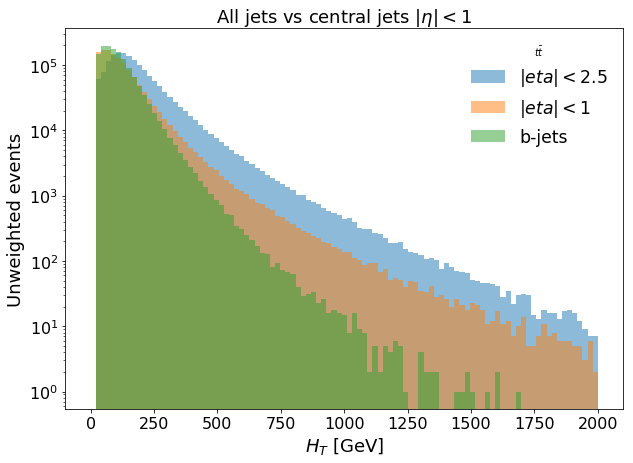

In [13]:
fig = plt.figure(figsize=(10, 7))

# Compute usual HT jets
HTjets = np.sum(jet_pt_ht, axis=1)
ax = plt.hist(HTjets[HTjets > 0], alpha=0.5, bins=np.linspace(
    0, 2000, 100), label='$|eta|<2.5$', log=True)

# Compute HT only with central jets
central_jet_pt_ht = jet_pt_ht*(np.abs(jet_eta) < 1.0)
HTjets_central = np.sum(central_jet_pt_ht, axis=1)
ax = plt.hist(HTjets_central[HTjets_central > 0], alpha=0.5, bins=np.linspace(
    0, 2000, 100), label='$|eta|<1$', log=True)

# Compute HT only with b-jets
bjets_pt_ht = jet_pt_ht*(jet_btagw > 0.67)
HTbjets = np.sum(bjets_pt_ht, axis=1)
ax = plt.hist(HTbjets[HTbjets > 0], alpha=0.5, bins=np.linspace(
    0, 2000, 100), label='b-jets', log=True)

ax = plt.title('All jets vs central jets $|\eta|<1$')
ax = plt.xlabel('$H_T$ [GeV]')
ax = plt.ylabel('Unweighted events')
ax = plt.legend(title='$t\\bar{t}$')

### *Apparte:* difference between `a*(a>x)` and `a[a>x]`

First of all `a>x` is an array filled with `True` or `False` depending on whether the condition is true or false (in numpy jargon, it's called a *mask*). What do the two diffent commands is:
   + `a[a>x]` return all element of a which pass the condition. In practice, it removes the other elements from the array.
   + `a*(a>x)` return and *and* between `a` and `a>x`. In practice, it replaces the values not passing the condition by by `False` or `0`. 
   + if `a` is multi-dimentional, `a[a>x]` will be a flat (1D) array. This is unavoidable since the output would be a jagged array. Indeed, for a 2D array, 
   the number of elements per line might depends on the line.

This is illustrated with examples below for both 1D and 2D arrays.

In [14]:
# 1D arrays
a = np.arange(12)
print('a       = {}'.format(a))
print('a>4     = {}'.format(a > 4))
print('a*(a>4) = {}'.format(a*(a > 4)))
print('a[a>4]  = {}'.format(a[a > 4]))

a       = [ 0  1  2  3  4  5  6  7  8  9 10 11]
a>4     = [False False False False False  True  True  True  True  True  True  True]
a*(a>4) = [ 0  0  0  0  0  5  6  7  8  9 10 11]
a[a>4]  = [ 5  6  7  8  9 10 11]


In [15]:
# 2D arrays
a = np.arange(12).reshape(6, 2)
print('a       = {}'.format(a))
print('a>4     = {}'.format(a > 4))
print('a*(a>4) = {}'.format(a*(a > 4)))
print('a[a>4]  = {}'.format(a[a > 4]))

a       = [[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]]
a>4     = [[False False]
 [False False]
 [False  True]
 [ True  True]
 [ True  True]
 [ True  True]]
a*(a>4) = [[ 0  0]
 [ 0  0]
 [ 0  5]
 [ 6  7]
 [ 8  9]
 [10 11]]
a[a>4]  = [ 5  6  7  8  9 10 11]


# Perform computations that would normally be done in an event loop

There are many obvious use cases of doing such a thing: 
  + identify the jet which is the closest of a given lepton (minimum $\Delta R$ computation)
  + compute invariant mass between all possible electrons and find the combination corresponding to a $Z$ decay
  + find the jet pair which best match a hadronic $W$ decay

In principle, the same methodology could be applied to combination having more than 2 objects (rough decay reconstruction). But this starts to be quite long to compute because we have to deal with large number of objects (the max one, in order to get fixed-size array). One option though, is to limit the number of object participating to the combination, by taking for example the 5th first leading $p_T$ jets. In our current example, this would reduce the number of jets from 13 to 5 (in term of N(N-1)/2 combinations: 78 to 10).


## Getting all possible pairs of two collections

In [16]:
# The following command is heavy for the current resources with 1.6M x 150
# possible combinations ... It seems (kernel deconnection):
#  --> jet_pairs=npu.all_pairs_nd(jets)
#
# Two options are proposed below.
#
# 1. jets[::2] to reduce the stat by a factor 2
%timeit npu.all_pairs_nd(jets[::2])

# 2. all_pairs_nd(jets,N) to considers only the Nth leading jets
%timeit npu.all_pairs_nd(jets, Nmax=5)

jet_pairs = npu.all_pairs_nd(jets[::2])

1 loop, best of 3: 1.29 s per loop
1 loop, best of 3: 410 ms per loop


### How to select only events with at least two objects?

In the case of making pairs of the two same objects, one needs to make sure there are at least two! Let's take the example of jets:
   
   1. we need to compute the number of jets, *i.e.* the number of not `nan` per event (since empty elements are set to `nan`), which can be done for any variable (here $p_T$):
   ```python
   nj=npu.count_nonnan(jets[...,0],axis=1)
   ```
   
   2. Select all jets and all variables for events with `nj>1`:
   ```python
   jets_atl2 = jets[nj>1,...]
   ```

## Compute pair-related observables

Once the pairs are formed, we can do any computation with it. For convenience, you can make two variables being the first jet `j1` and the second jet `j2` of the pair. Those will be array of shape (Nevt,Npair,Nvar):

In [17]:
j1, j2 = jet_pairs[:, :, 0, :], jet_pairs[:, :, 1, :]
print(j1.shape, j2.shape)

((811440, 78, 5), (811440, 78, 5))


### Minimum $\Delta R(j,j)$
We can then take the sum, the difference, the invariant mass or anthing else based on `j1` and `j2`. Below, we form the array of $(\Delta\eta,\Delta\phi)$ for each pair, having a shape (Nevt,Npair,2):

In [18]:
# keep only eta,phi to compute dR=sqrt(deta^2+dphi^2)
dj_etaphi = j1[..., 1:3]-j2[..., 1:3]
# remove nan by a relevant default values (outside plots)
dj_etaphi = npu.replace_nan(dj_etaphi, value=999)
# print the 5th first pair of the 3rd event
print(dj_etaphi.shape, dj_etaphi[2, 0:5])

((811440, 78, 2), array([[-1.6681726 , -0.86051571],
       [-0.57334256, -2.1195178 ],
       [-1.17937791,  1.9002111 ],
       [-1.0380528 , -1.7438587 ],
       [-1.2381618 , -0.3073993 ]], dtype=float32))


In [19]:
dR = np.sum(dj_etaphi**2, axis=2)**0.5
print(dR.shape, dR[0, 0:5])

((811440, 78), array([    3.5524466 ,  1412.79931641,  1412.79931641,  1412.79931641,
        1412.79931641], dtype=float32))


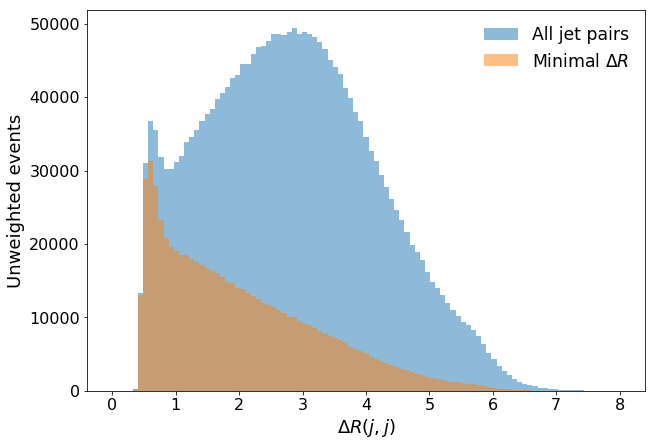

In [20]:
fig = plt.figure(figsize=(10, 7))
ax = plt.hist(dR.flatten(), bins=np.linspace(
    0, 8, 100), alpha=0.5, label='All jet pairs')
ax = plt.hist(np.min(dR, axis=1), bins=np.linspace(
    0, 8, 100), alpha=0.5, label='Minimal $\Delta R$')
ax = plt.xlabel('$\Delta R(j,j$)')
ax = plt.ylabel('Unweighted events')
ax = plt.legend()

### Minimum $\Delta R(j,e)$

In [21]:
jet_direction = jets[:, :, 1:3]
ele_direction = npu.df2array(df, ['el_eta', 'el_phi'])

In [22]:
jet_ele_pairs_direction = npu.all_pairs_nd(jet_direction, ele_direction)

In [23]:
dej = jet_ele_pairs_direction[:, :, 0, :]-jet_ele_pairs_direction[:, :, 1, :]
dRej = npu.replace_nan(np.sum(dej**2, axis=2)**0.5, value=999)
dRmin = np.min(dRej, axis=1)

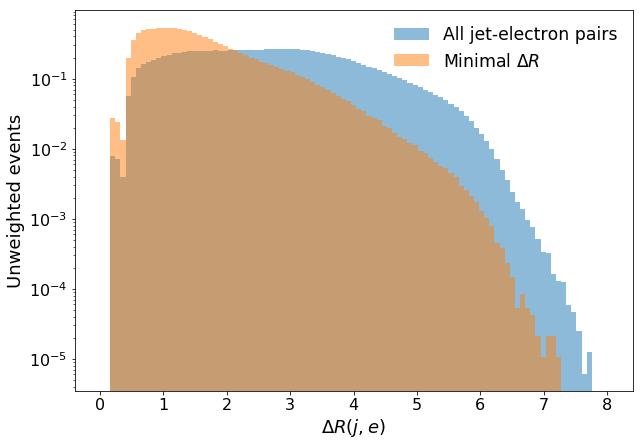

In [24]:
fig = plt.figure(figsize=(10, 7))
style = {
    'bins': np.linspace(0, 8, 100),
    'alpha': 0.5,
    'density': True,
    'log': True,
}
ax = plt.hist(dRej.flatten(), label='All jet-electron pairs', **style)
ax = plt.hist(dRmin, label='Minimal $\Delta R$', **style)
ax = plt.xlabel('$\Delta R(j,e)$')
ax = plt.ylabel('Unweighted events')
ax = plt.legend()

### Di-jet invariant masses

Let's take the example of the invariant mass betwee `j1` and `j2`:

$$
m^2 = {p^2_{T}}_{1} {p^2_{T}}_{2} \left( \cosh(\eta_1-\eta_2) - \cos(\phi_1-\phi_2) \right) 
$$

In [25]:
deta, dphi = dj_etaphi[..., 0], dj_etaphi[..., 1]
pt1, pt2 = j1[..., 0], j2[..., 0]
print(pt1.shape, deta.shape)

((811440, 78), (811440, 78))


In [26]:
m = np.sqrt(pt1*pt2 * (np.cosh(deta)-np.cos(dphi))) / 1000.
m = npu.replace_nan(m, 1e10)
print(m.shape)

(811440, 78)


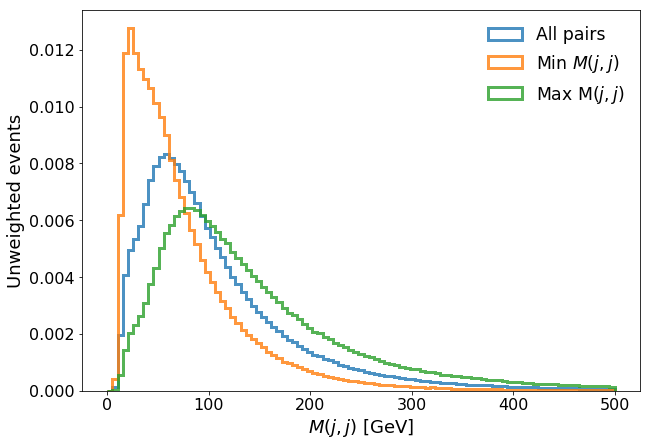

In [27]:
fig = plt.figure(figsize=(10, 7))
style = {
    'bins': np.linspace(0, 500, 100),
    'alpha': 0.8,
    'density': True,
    'log': False,
    'histtype': 'step',
    'linewidth': 3.0
}
ax = plt.hist(m.flatten(), label='All pairs', **style)
ax = plt.hist(np.min(m, axis=1), label='Min $M(j,j)$', **style)
ax = plt.hist(np.max(npu.replace_val(m, 1e10, -1e10), axis=1),
              label='Max M$(j,j)$', **style)
ax = plt.xlabel('$M(j,j)$ [GeV]')
ax = plt.ylabel('Unweighted events')
ax = plt.legend()

# Build up system of several collections (e.g. electrons and jets)

Explain what is it ... basically building a colletion made of several entities: *e.g.* `lep={el+mu}` or `EMobj={jets+ele}`


## Preamble: implementing default values like `df2array(df,['var1','var2','999'])`

This would be useful to work around the constrain of having the same number of variable per object. For example, if one want to make all possible pairs of electrons and jets or simply group the collection together, we need to have the same dimension along the variable axis (*i.e.* axis=3). Of course, variables for jets might not exist for electrons (or the opposit). Concretely, the following code
```python
jets      = df2array(df,['jet_pt','jet_eta','jet_phi','jet_mv2c10','jet_isbtagged_77'])
electrons = df2array(df,['el_pt' ,'el_eta' ,'el_phi'])
ele_jets  = all_pairs_nd(jets,electrons)
```
will not work and will return something like
```
NameError: The shape along all dimensions but the one of axis=1 should be equal, while here:
  -> shape of a is (1000, 8, 5) 
  -> shape of b is (1000, 3, 3) 
```

The adopted possibility is to be able to set a default value just to have the proper number of variable for both object **and** remember that this is a dummy value, like
```python
jets      = df2array(df,['jet_pt','jet_eta','jet_phi','jet_mv2c10','jet_isbtagged_77'])
electrons = df2array(df,['el_pt' ,'el_eta' ,'el_phi' ,      '-999',             'nan'])
ele_jets  = all_pairs_nd(jets,electrons)
```

Since `jets` currently contains 5 variables, one needs to build up a collection of electrons with 5 variables. But the btagg weight is not defined for electron, se we put a dummy value (otherwise the stacking cannot work).

In [28]:
print(jets.shape)

(1622880, 13, 5)


In [29]:
eles = npu.df2array(df, ['el_pt', 'el_eta', 'el_phi', 'nan', 'nan'])

In [30]:
jets_eles = npu.stack_collections([jets, eles])
print(jets.shape, eles.shape, jets_eles.shape)

((1622880, 13, 5), (1622880, 3, 5), (1622880, 16, 5))


In [31]:
jet_el_pt = npu.replace_nan(jets_eles[:, :, 0])
jet_el_HT = np.sum(jet_el_pt/1000., axis=1)
print(jet_el_HT.shape)

(1622880,)


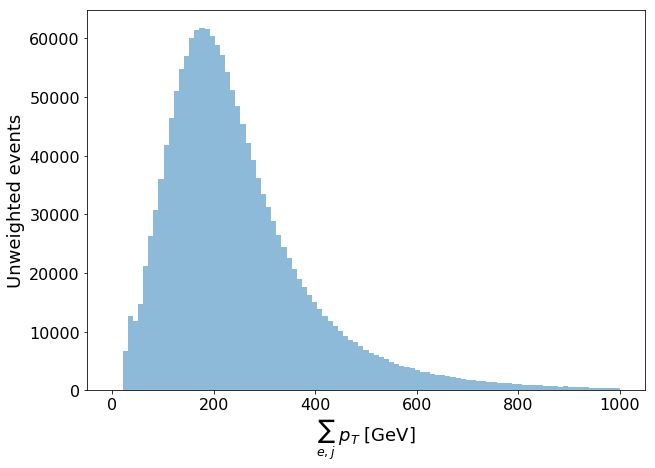

In [32]:
fig = plt.figure(figsize=(10, 7))
plt.hist(jet_el_HT[jet_el_HT > 0], bins=np.linspace(0, 1000, 100), alpha=0.5)
ax = plt.xlabel('$\sum_{e,j} \; p_T$ [GeV]')
ax = plt.ylabel('Unweighted events')

# Select an object based on event-based criteria (distance, invariant mass, etc ...)

The goal of this section is to look at say the isolation of the leptons which form a pair having $M(e,e)\sim M(Z)$.

## E.g. 1: compare the b-tagging weight of the jet closest to an electron and the others

We reform all the pair here, but not only with the direction but all needed variables:

---
<p style='color:red'>
**HERE WE RESTRIC TO N EVENTS BECAUSE IT MAKES THE KERNEL STOPED OTHERWISE : NEED TO BE UNDERSTOOD**
</p>

In [52]:
n = 200000

---

In [53]:
jets_elec_pairs = npu.all_pairs_nd(jets[:n], eles[:n])
print(jets[:n].shape, eles[:n].shape, jets_elec_pairs.shape)

((200000, 13, 5), (200000, 3, 5), (200000, 39, 2, 5))


Then we need to isolate an array of shape (Nevt,Npair) contanining the btagg weight (3rd variable) of the first element (*i.e.* the jet) for any pair: `btagw=jets_ele[:,:,0,3]`

In [54]:
jet_btag_w = npu.replace_nan(jets_elec_pairs[:, :, 0, 3], value=999)

Reminder of $dR(e,j)$ and min$dR(e,j)$ distribution (already computed from before):

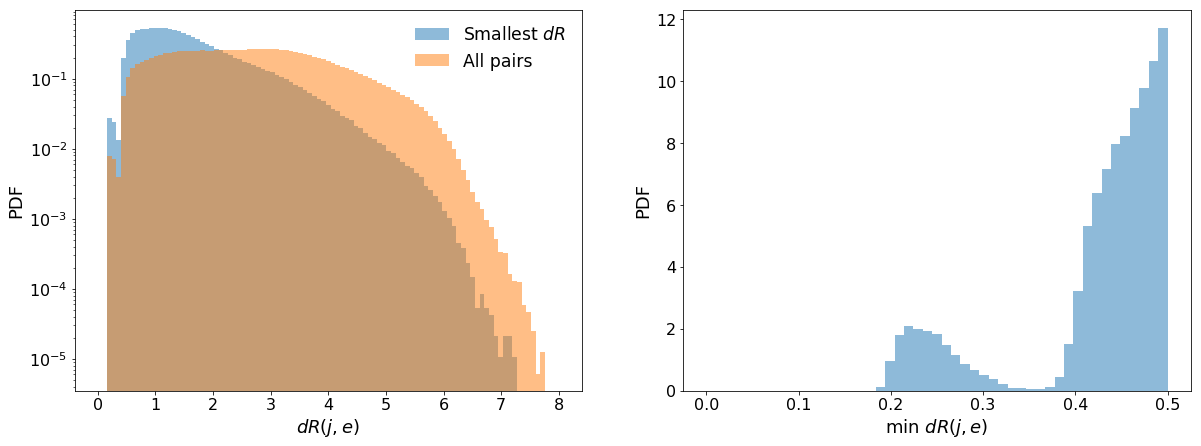

In [55]:
fig = plt.figure(figsize=(20, 7))
plt.subplot(121)
ax = plt.hist(dRmin, bins=np.linspace(0, 8, 100), alpha=0.5,
              density=True, log=True, label='Smallest $dR$')
ax = plt.hist(dRej.flatten(), bins=np.linspace(0, 8, 100),
              alpha=0.5, density=True, log=True, label='All pairs')
ax = plt.xlabel('$dR(j,e)$')
ax = plt.ylabel('PDF')
ax = plt.legend()

plt.subplot(122)
ax = plt.hist(dRmin, bins=np.linspace(0, 0.5, 50), alpha=0.5, density=True)
ax = plt.xlabel('min $dR(j,e)$')
ax = plt.ylabel('PDF')

Getting now the index of the pair having the minimal $dR$ using the command `np.argmin(dRej,axis=1)` which return a 1D array of shape (Nevt) containing the wanted index for each event. Then one can use the functions `get_indexed_value()` and `get_all_but_indexed_value()` to get either the btag weight of the minimal $dR$ or all the others.

In [56]:
idRmin = np.argmin(dRej[:n], axis=1)
jet_btag_w_dRmin = npu.get_indexed_value(jet_btag_w, idRmin)
jet_btag_w_other = npu.get_all_but_indexed_value(jet_btag_w, idRmin)

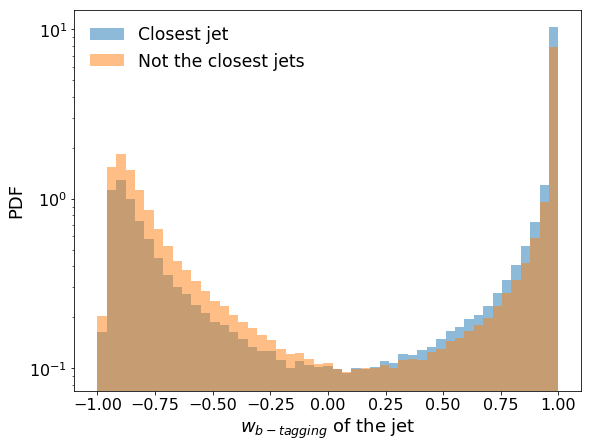

In [57]:
fig = plt.figure(figsize=(20, 7))
plt.subplot(121)
ax = plt.hist(jet_btag_w_dRmin, bins=np.linspace(-1, 1, 50),
              alpha=0.5, density=True, log=True, label='Closest jet')
ax = plt.hist(jet_btag_w_other.flatten(), bins=np.linspace(-1, 1, 50),
              alpha=0.5, density=True, log=True, label='Not the closest jets')
ax = plt.xlabel('$w_{b-tagging}$ of the jet')
ax = plt.ylabel('PDF')
ax = plt.legend()

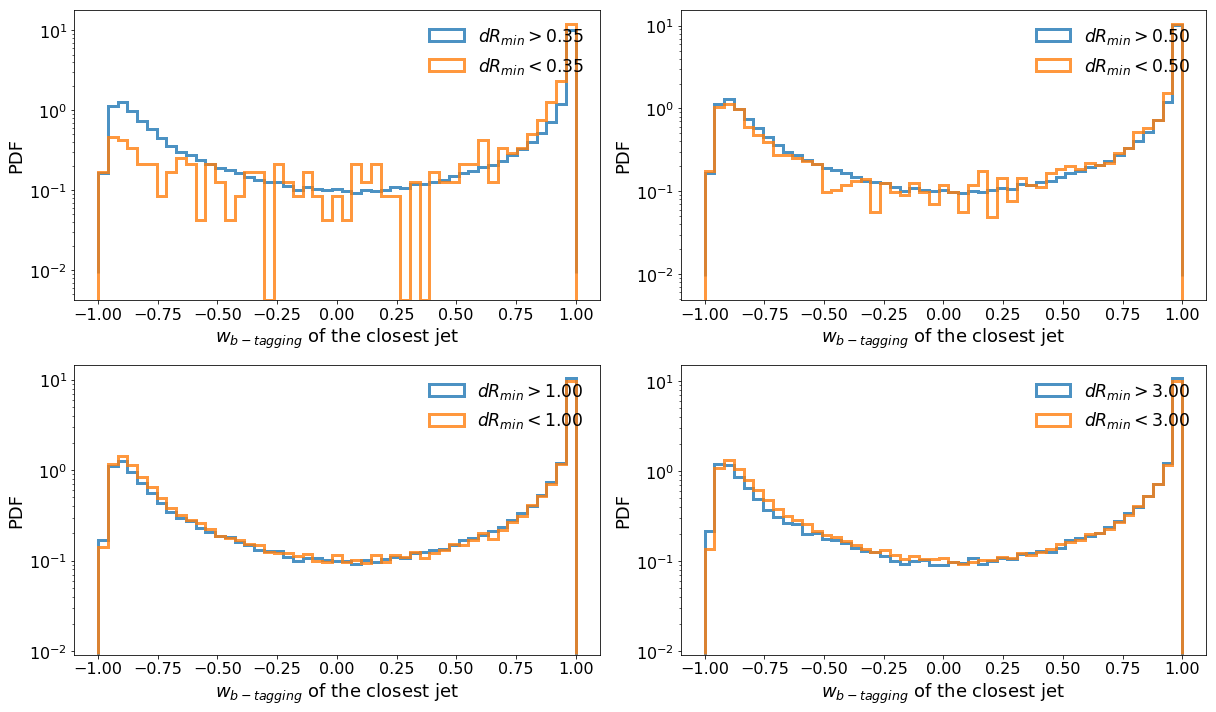

In [58]:
fig = plt.figure(figsize=(17, 10))
style = {
    'bins': np.linspace(-1, 1, 50),
    'alpha': 0.8,
    'density': True,
    'log': True,
    'histtype': 'step',
    'linewidth': 3.0
}
for i, cut in enumerate([0.35, 0.5, 1.0, 3.0]):
    plt.subplot(2, 2, i+1)
    dRgt_btag = jet_btag_w_dRmin*(dRmin[:n] > cut)
    dRgt_btag[dRgt_btag == 0] = 999
    dRlt_btag = jet_btag_w_dRmin*(dRmin[:n] < cut)
    dRlt_btag[dRlt_btag == 0] = 999
    ax = plt.hist(dRgt_btag, label='$dR_{min}>'+'{:.2f}$'.format(cut), **style)
    ax = plt.hist(dRlt_btag, label='$dR_{min}<'+'{:.2f}$'.format(cut), **style)
    ax = plt.xlabel('$w_{b-tagging}$ of the closest jet')
    ax = plt.ylabel('PDF')
    ax = plt.legend()
plt.tight_layout()

In [40]:
Nmax = 1000
N = np.arange(Nmax)
print('\nUsing addition of python native lists:')
%timeit np.array([list(jet_btag_w[i, :idRmin[i]])+list(jet_btag_w[i, idRmin[i]+1:]) for i in N])

print('\nUsing np.delete()')
%timeit np.array([np.delete(jet_btag_w[i, :], idRmin[i]) for i in N])

print('\nUsing np.concatenate()')
%timeit np.array([np.concatenate([jet_btag_w[i, :idRmin[i]], jet_btag_w[i, idRmin[i]+1:]]) for i in N])


Using addition of python native lists:
100 loops, best of 3: 8.46 ms per loop

Using np.delete()
100 loops, best of 3: 7.63 ms per loop

Using np.concatenate()
100 loops, best of 3: 2.36 ms per loop


## E.g. 2: $p_T$ distribution for jets forming the highest $M(j,j)$

In [41]:
j1, j2 = jet_pairs[:, :, 0, :], jet_pairs[:, :, 1, :]
deta, dphi = j1[..., 1]-j2[..., 1], j1[..., 2]-j2[..., 2]
pt1, pt2 = j1[..., 0], j2[..., 0]
mjj = npu.replace_nan(
    np.sqrt(pt1*pt2 * (np.cosh(deta)-np.cos(dphi)))/1000., -1e10)

In [42]:
i_mjj_max = np.argmax(mjj, axis=1)
pt_mjj_max = np.concatenate([
    npu.get_indexed_value(pt1, i_mjj_max)/1000,
    npu.get_indexed_value(pt2, i_mjj_max)/1000]
)

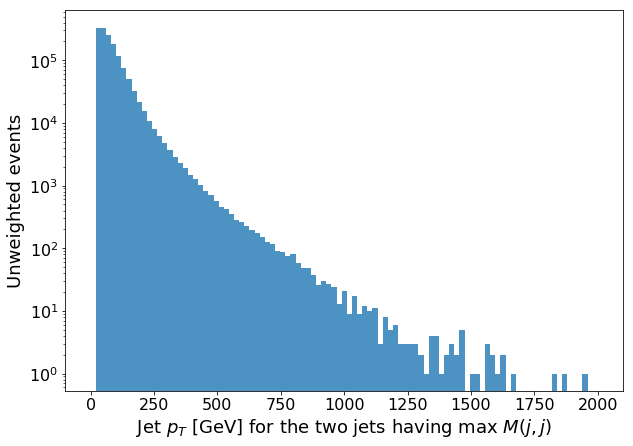

In [43]:
fig = plt.figure(figsize=(10, 7))
style = {
    'bins': np.linspace(0, 2000, 100),
    'alpha': 0.8,
    'log': True,
}
ax = plt.hist(npu.replace_nan(pt_mjj_max, -999), **style)
ax = plt.xlabel('Jet $p_T$ [GeV] for the two jets having max $M(j,j)$')
ax = plt.ylabel('Unweighted events')

# IO between `panda/numpy` and `ROOT`

## Save some variables back into a `ROOT` file

This is possible that one wants to save and share the obtained variables in a `ROOT` file. This is possible to do using a *structured array*, numpy object accepting both field different shape for each "column". This goes through a data type (which in for instance the event model) and then each column can be filled. This is in principle a simplified pandas dataframe (simplified but interfaced with `TTree` via `root_numpy`). **Note that every `np.nan` will manifest in `tree->Draw()` as 0.0**

In [44]:
from root_numpy import array2root

# Define the event model with ('name','type','shape') for each column
event_model = np.dtype([
    ('n_jets', 'i4'),
    ('jet_pt', 'f8', (jets.shape[1],)),
    ('jet_eta', 'f8', (jets.shape[1],)),
    ('jet_phi', 'f8', (jets.shape[1],)),
    ('ht', 'f8'),
    ('ht_cent', 'f8'),
])

# Create the giant structured array
events = np.zeros(jets.shape[0], dtype=event_model)
events['n_jets'] = npu.count_nonnan(jets[..., 0], axis=1)
events['jet_pt'] = jets[..., 0]
events['jet_eta'] = jets[..., 1]
events['jet_phi'] = jets[..., 2]
events['ht'] = HTjets
events['ht_cent'] = HTjets_central

# Convert it into a TTree stored in a ROOT file
array2root(events, 'ttbar_jets.root', 'tree_jets', mode='recreate')

## Read back the created file with `root_numpy` *WIP*

In [45]:
ar_new = root2array('ttbar_jets.root', 'tree_jets',
                    branches=['jet_pt']).view(np.recarray)
df_new = pd.DataFrame(ar_new, index=np.arange(len(ar_new)))

Exception: Data must be 1-dimensional